# Use direct outputs from MOM6 only to see what happens to the KE

We are outputting:
* dKE_dt
* FrictWork
* KE
* KE_horvisc
* KE_visc
* kvu
* PE_to_KE



In [1]:
import sys
sys.path.append("/home/149/ab8992/tasman-tides/")
import xarray as xr
import ttidelib as tt
import scipy
import cmocean
import os
from pathlib import Path
cmap = cmocean.cm.dense_r
import matplotlib
import matplotlib.pyplot as plt
earth_cmap = matplotlib.colormaps["gist_earth"]
from datetime import timedelta

# import filtering
import numpy as np
import dask
dask.config.set({'logging.distributed': 'error'})
from dask.distributed import Client,default_client
import xrft


client = tt.startdask()
client

<Client: 'tcp://127.0.0.1:43917' processes=7 threads=28, memory=112.00 GiB>


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 7
Total threads: 28,Total memory: 112.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:43917,Workers: 7
Dashboard: /proxy/8787/status,Total threads: 28
Started: Just now,Total memory: 112.00 GiB
Comm: tcp://127.0.0.1:38157,Total threads: 4
Dashboard: /proxy/39353/status,Memory: 16.00 GiB
Nanny: tcp://127.0.0.1:44359,


## First draft a function to calculate N(z)

$ \large N = \frac{-g}{\rho}\frac{\partial \rho}{\partial z} $


In [2]:
trange = 50
t0 = 3700
data = tt.collect_data(
            exptname="debug_ideal-20",
            rawdata = ["KE_visc","KE_horvisc","PE_to_KE","FrictWork","dKE_dt","KE","u","v"],
            timerange = (t0 - trange,t0 + trange)
        ).sel(yb = slice(-50,50))

data = data.assign_coords(
    {"xb" : data.xb * 1000,
     "yb" : data.yb * 1000,
     "time":data.time * 3600
}).load()

loading KE_visc...	done.
loading KE_horvisc...	done.
loading PE_to_KE...	done.
loading FrictWork...	done.
loading dKE_dt...	done.
loading KE...	done.
loading u...	done.
loading v...	done.


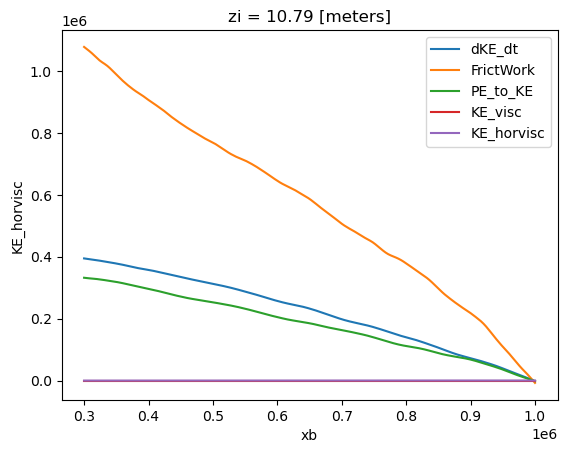

In [6]:
def BeamIntegral(field):
    DT = field.time[-1].values - field.time[0].values
    # d = field.fillna(0).sel(xb = slice(300000,1000000),yb = slice(-40000,40000)).isel(time = 10).integrate("yb") / DT
    d = field.fillna(0).sel(xb = slice(300000,1000000),yb = slice(-40000,40000)).isel(time = slice(0,99)).integrate("time").integrate("yb") / DT
    return d.integrate("xb") - d.cumsum("xb") * 4000

(BeamIntegral(data["dKE_dt"])).sel(zl = slice(300,4500)).sum("zl").plot(label = "dKE_dt")
(BeamIntegral(-1 * data["FrictWork"])).sel(zl = slice(300,4500)).sum("zl").plot(label = "FrictWork")
(BeamIntegral(data["PE_to_KE"])).sel(zl = slice(300,4500)).sum("zl").plot(label = "PE_to_KE")
(BeamIntegral(data["KE_visc"])).sel(zl = slice(300,4500)).sum("zl").plot(label = "KE_visc")
(BeamIntegral(data["KE_horvisc"])).sel(zl = slice(300,4500)).sum("zl").plot(label = "KE_horvisc")
plt.legend()

In [65]:
data.KE.attrs

{'_FillValue': nan,
 'units': 'm2 s-2',
 'long_name': 'Layer kinetic energy per unit mass',
 'cell_methods': 'area:mean z_l:mean yh:mean xh:mean time: point',
 'Description': 'Beamwidth 400km, Beamlength 1500km, Resolution 4.0km, angle 0.36520144978817304 degrees, origin (-42.1, 147.2)',
 'coordinates': 'lat lon'}

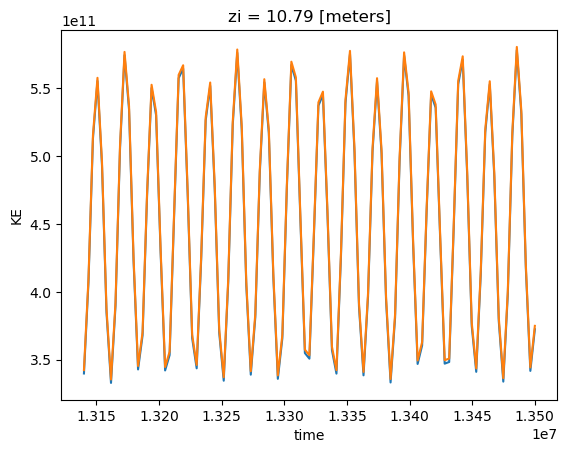

In [67]:
(0.5 * data.u**2 + 0.5 * data.v**2).fillna(0).sel(xb = slice(300000,1200000)).integrate("xb").integrate("yb").integrate("zl").plot()
data.KE.fillna(0).sel(xb = slice(300000,1200000)).integrate("xb").integrate("yb").integrate("zl").plot()

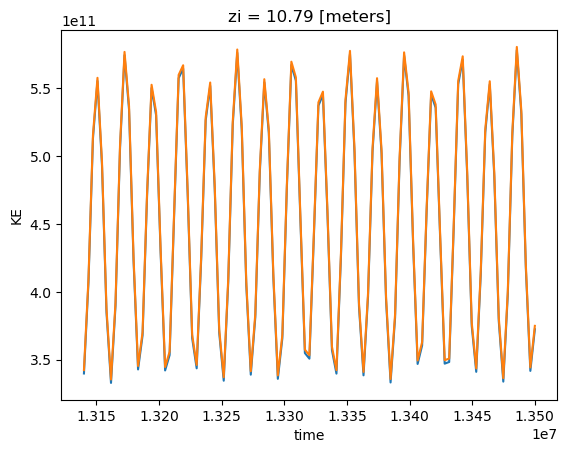

In [66]:
(0.5 * data.u**2 + 0.5 * data.v**2).fillna(0).sel(xb = slice(300000,1200000)).integrate("xb").integrate("yb").integrate("zl").plot()
data.KE.fillna(0).sel(xb = slice(300000,1200000)).integrate("xb").integrate("yb").integrate("zl").plot()

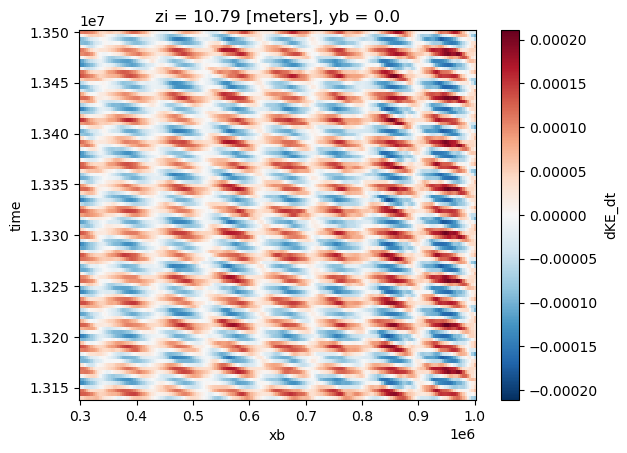

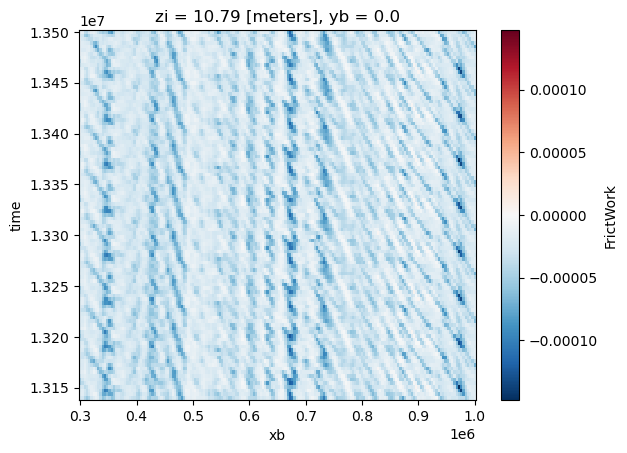

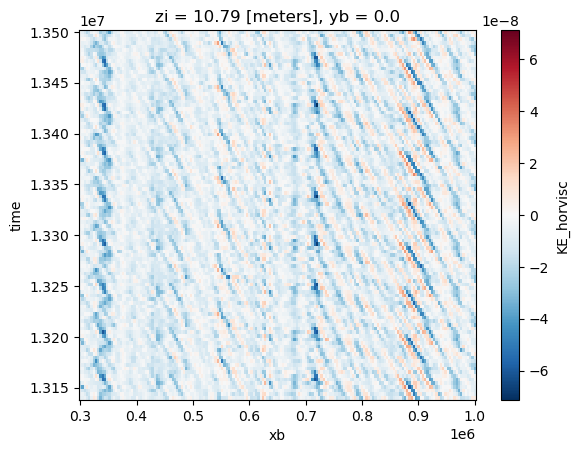

In [60]:
data.sel(xb = slice(300000,1000000)).dKE_dt.sum("zl").sel(yb = 0).plot()
plt.figure()
data.sel(xb = slice(300000,1000000)).FrictWork.sum("zl").sel(yb = 0).plot()
plt.figure()
data.sel(xb = slice(300000,1000000)).KE_horvisc.sum("zl").sel(yb = 0).plot()

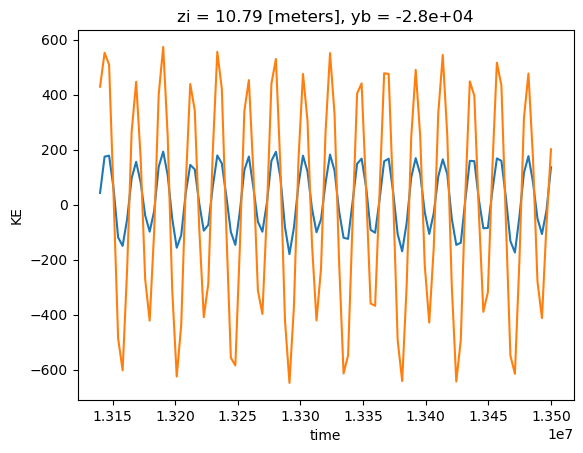

In [45]:

data.dKE_dt.isel(yb = 5).fillna(0).integrate("xb").sum("zl").plot()
(data.KE.isel(yb = 5)).fillna(0).differentiate("time").integrate("zl").integrate("xb").plot()



In [20]:
data.KE_visc.attrs

{'_FillValue': nan,
 'units': 'm3 s-3',
 'long_name': 'Kinetic Energy Source from Vertical Viscosity and Stresses',
 'cell_methods': 'area:mean z_l:mean yh:mean xh:mean time: point',
 'Description': 'Beamwidth 400km, Beamlength 1500km, Resolution 4.0km, angle 0.36520144978817304 degrees, origin (-42.1, 147.2)',
 'coordinates': 'lat lon'}

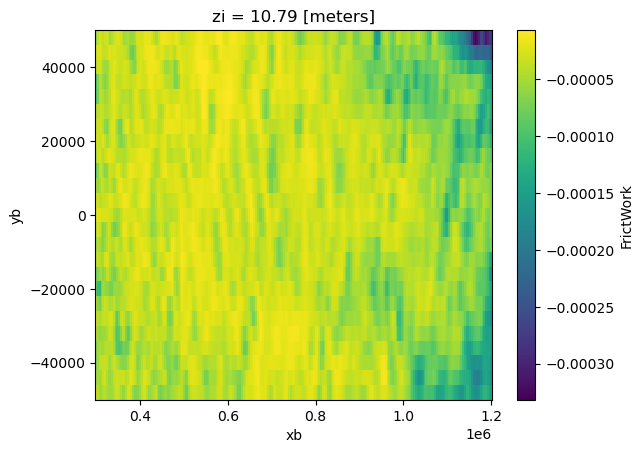

In [10]:
data.FrictWork.sel(xb = slice(300000,1200000)).sum("zl").mean("time").plot()

### Self interaction term

## $ (u \cdot \nabla u_1) u_1 = u \cdot \phi(z) \phi'(z) \nu(x,y,t) \nabla \cdot \nu(x,y,t) $

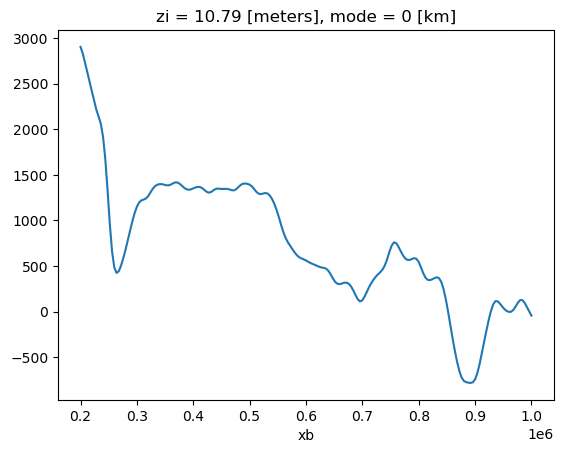

In [12]:
def self_interact(u,U,phi):
    return u * phi**2 * U * U.differentiate("xb")

SI_1 = self_interact(data.u,U.isel(mode = 0),phi.isel(mode = 0)) + self_interact(data.v,U.isel(mode = 0),phi.isel(mode = 0))

BeamIntegral(SI_1).sel(zl = slice(0,5000)).integrate("zl").plot(label = "Self Interaction")

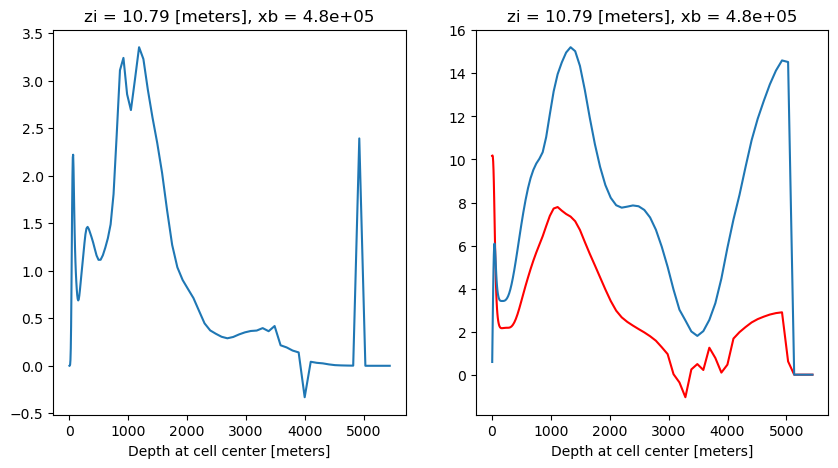

In [11]:
fig,ax = plt.subplots(1,2,figsize = (10,5))
x = 70
BeamIntegral(-1 * data.KE_horvisc).isel(xb = x).plot(ax = ax[1],label = "diagnosed hvisc",color = "red")
BeamIntegral(
    data.zl * (data.u.differentiate("xb").differentiate("xb") + data.v.differentiate("yb").differentiate("yb"))**2 * ahh
    ).isel(xb = x).plot(ax = ax[1],label = "Horizontal Visc")


# BeamIntegral(-1 * data.KE_visc).sel(zl = slice(0,None)).isel(xb = x).plot(ax = ax[0],label = "diagnosed hvisc",color = "red")
BeamIntegral(
    data.zl * (data.u.differentiate("zl")**2 + data.v.differentiate("zl")**2) * data.kvu
    ).isel(xb = x).sel(zl = slice(0,None)).plot(ax = ax[0],label = "Horizontal Visc")

/g/data/hh5/public/apps/miniconda3/envs/analysis3-24.04/lib/python3.10/site-packages/xarray/core/computation.py:821: RuntimeWarning: invalid value encountered in log
  result_data = func(*input_data)


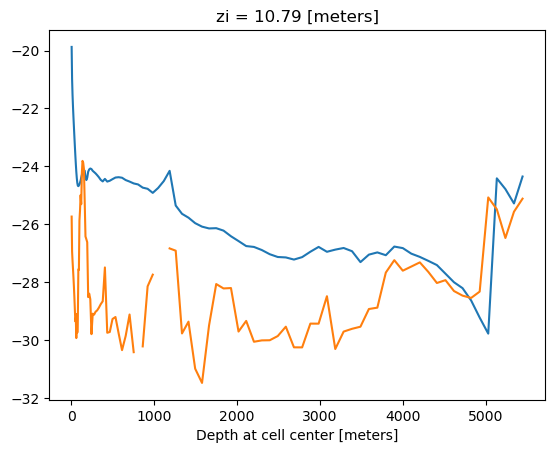

In [ ]:
np.log(-1 * data.KE_horvisc.mean("xb").mean("yb").mean("time") / data.zl).plot()
np.log(-1 * data.KE_visc.mean("xb").mean("yb").mean("time") / data.zl).plot()


## Calculate energy flux from the existing eigenvalues for u,v

$ \large \tilde{P} = - \rho_0 \int \left( \frac{\partial \tilde{U}}{\partial t} - f \tilde{V} \right) dx + \tilde{P_0}(y,t) $

$ \large b= \frac{1}{\rho_0} \partial_z P $

$ \large b= \frac{1}{\rho_0} \partial_z \phi \tilde{P} $

where $\phi$ is the horizontal velocity eigenfunction, and tildes denote eigenvalues, i.e the horizontal components of velocities s.t $u = \tilde{u}(x,y,t) \phi(z)$

This cell is quite a mess since I had to deal with dividing by zeroes in some areas, since N and phi do vary in x,y with topo outside flattened area. This will need revising for other cases where N and phi change also along beam path

Text(0.5, 1.0, 'All modes')

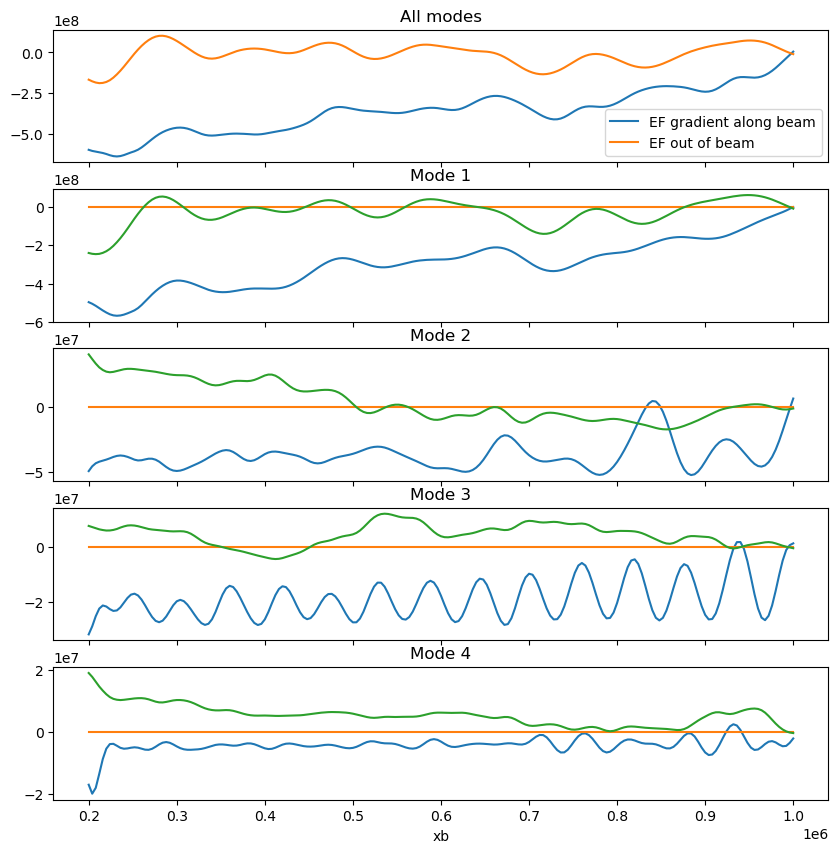

In [10]:
def EnergyFlux(U,V,phi,N):
    f = -0.0001
    rho0 = 1023
    P = rho0 * xr.DataArray(
        data = - scipy.integrate.cumulative_trapezoid(
                (U.differentiate("time") / 3600 - f * V),
                x = U.xb,
                initial = 0
            ),
        dims = U.dims,
        coords = U.coords
    )
    P -= P.mean("xb")
    b_z = phi.differentiate("zl")
    b2_N2 = (phi.differentiate("zl")**2 / N**2).fillna(0)
    b2_N2 = b2_N2.where(np.isfinite(b2_N2),0).integrate("zl")
    APE = 0.5 * (
        (P / rho0)**2 * b2_N2
        )
    KE = 0.5 * (U**2 + V**2)
    EF_along = (-1 * U * P)
    EF_out = (V * P).isel(yb = -1) - (V * P).isel(yb = 0)

    return xr.merge([APE.rename("APE"),KE.rename("KE"),EF_along.rename("EF_along"),EF_out.rename("EF_out")])
DT = U.time[-1] - U.time[0]
D = ahh * (U.differentiate("xb").differentiate("xb") + V.differentiate("yb").differentiate("yb"))**2
D = D.fillna(0).sel(xb = slice(200000,1000000),yb = slice(-40000,40000)).integrate("yb").integrate("time").integrate("zl").load() / DT
EF = (
    EnergyFlux(U,V,phi,N)[["EF_along","EF_out"]].integrate("time") / DT
).sel(xb = slice(200000,1000000),yb = slice(-40000,40000)).integrate("yb").load()

fig,ax = plt.subplots(5,1,figsize = (10,10))
for i in range(4):
    (
        EF.EF_along.isel(mode = i).differentiate("xb").cumsum("xb") * (EF.xb[1]- EF.xb[0]) - 
        EF.EF_along.isel(mode = i).differentiate("xb").integrate("xb")
    ).plot(ax = ax[i + 1])
    D.isel(mode = i).plot(ax = ax[i + 1],label = "D")    
    (
        EF.EF_out.isel(mode = i).cumsum("xb") * (EF.xb[1]- EF.xb[0]) - 
        EF.EF_out.isel(mode = i).integrate("xb")
    ).plot(ax = ax[i + 1])    
    ax[i + 1].set_title(f"Mode {i + 1}")
    ax[i].set_xticklabels([])
    ax[i].set_xlabel("")
(
    EF.EF_along.sum("mode").differentiate("xb").cumsum("xb") * (EF.xb[1]- EF.xb[0]) - 
    EF.EF_along.sum("mode").differentiate("xb").integrate("xb")
).plot(ax = ax[0],label = "EF gradient along beam")
(
    EF.EF_out.sum("mode").cumsum("xb") * (EF.xb[1]- EF.xb[0]) - 
    EF.EF_out.sum("mode").integrate("xb")
).plot(ax = ax[0],label = "EF out of beam")
ax[0].legend()
ax[0].set_xlabel("")
ax[0].set_title("All modes")

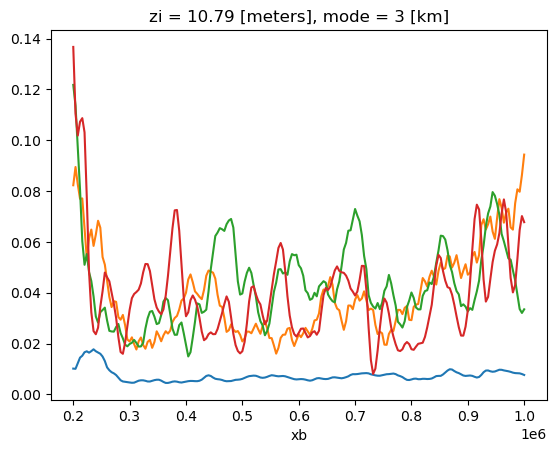

In [14]:
for i in range(4):
    D.isel(mode = i).plot()

In [ ]:
## Now calculate the dissipation rate in space
M2 = (28.984104 / 360) / (3600) 
M2 = 1 / M2# M2 period in seconds
# Calculate phase speed
group_speed = (wavelength * 1000/ M2).sel(xb = 500000,yb = 0,method = "nearest").differentiate("xb") # Phase speed in m/s

D = ahh * (U.differentiate("xb").differentiate("xb") + V.differentiate("yb").differentiate("yb"))**2
D_slope = D / phi

mode = 1
(D_slope.sel(xb = slice(400000,1000000)).fillna(0).sel(zl = slice(0,50)).integrate("zl").sum("mode").mean("time").sel(yb = 0)).plot()
# ((ke.sel(xb = slice(400000,1000000)).differentiate("xb"))).sum("mode").plot()
